In [1]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

In [2]:
df_original = pd.read_csv('mktmix.csv')
df = df_original.copy()

### df info

In [3]:
df.head()

,NewVolSales,Base_Price,Radio,InStore,NewspaperInserts,Discount,TV,Stout,Website_Campaign
0,19564,15.029276,245.0,15.452,NaN,0.000,101.780000,2.28342,NaN
1,19387,15.029276,314.0,16.388,NaN,0.000,76.734000,2.22134,NaN
2,23889,14.585093,324.0,62.692,NaN,0.050,131.590200,2.00604,NaN
3,20055,15.332887,298.0,16.573,NaN,0.000,119.627060,2.19897,NaN
4,20064,15.642632,279.0,41.504,NaN,0.045,103.438118,1.81860,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NewVolSales        104 non-null    int64  
 1   Base_Price         104 non-null    float64
 2   Radio              100 non-null    float64
 3   InStore            104 non-null    float64
 4   NewspaperInserts   6 non-null      object 
 5   Discount           104 non-null    float64
 6   TV                 104 non-null    float64
 7   Stout              104 non-null    float64
 8   Website_Campaign   14 non-null     object 
dtypes: float64(6), int64(1), object(2)
memory usage: 7.4+ KB


In [5]:
df.isnull().sum()

NewVolSales           0
Base_Price            0
Radio                 4
InStore               0
NewspaperInserts     98
Discount              0
TV                    0
Stout                 0
Website_Campaign     90
dtype: int64

In [6]:
df.describe()

,NewVolSales,Base_Price,Radio,InStore,Discount,TV,Stout
count,104.000000,104.000000,100.000000,104.000000,104.000000,104.000000,104.000000
mean,20171.067308,15.306740,256.690000,32.918567,0.022059,141.009774,2.545966
std,1578.604670,0.528902,86.994682,13.682570,0.027668,42.949231,0.310070
min,17431.000000,13.735724,0.000000,10.782000,0.000000,37.656174,1.818600
25%,19048.750000,15.029276,235.000000,22.183750,0.000000,117.108343,2.316450
50%,19943.500000,15.332887,278.500000,31.161500,0.000000,138.581542,2.502120
75%,20942.750000,15.642632,313.250000,41.079000,0.049423,175.681780,2.814315
max,24944.000000,16.281020,399.000000,68.119000,0.090763,240.291967,3.158620


### feature engineering

In [7]:
df['NewspaperInserts'] = df['NewspaperInserts'].map({'Insert':1, '0':0})
df = df.fillna(0)
df['Radio '] = df['Radio '].replace(0, df['Radio '].median())
df = df.drop(columns=["Website_Campaign "])
df.head()

,NewVolSales,Base_Price,Radio,InStore,NewspaperInserts,Discount,TV,Stout
0,19564,15.029276,245.0,15.452,0.0,0.000,101.780000,2.28342
1,19387,15.029276,314.0,16.388,0.0,0.000,76.734000,2.22134
2,23889,14.585093,324.0,62.692,0.0,0.050,131.590200,2.00604
3,20055,15.332887,298.0,16.573,0.0,0.000,119.627060,2.19897
4,20064,15.642632,279.0,41.504,0.0,0.045,103.438118,1.81860


### feature descriptives

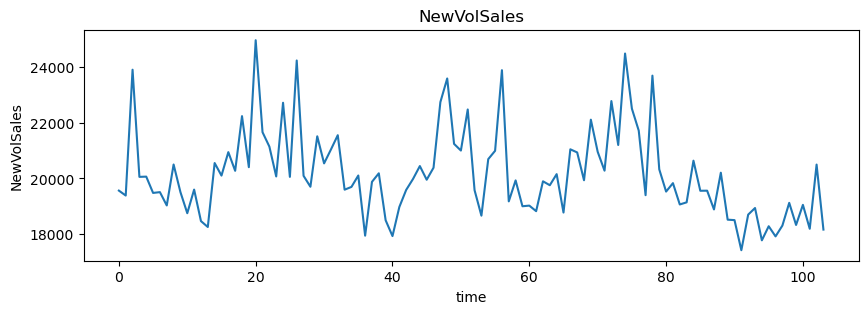

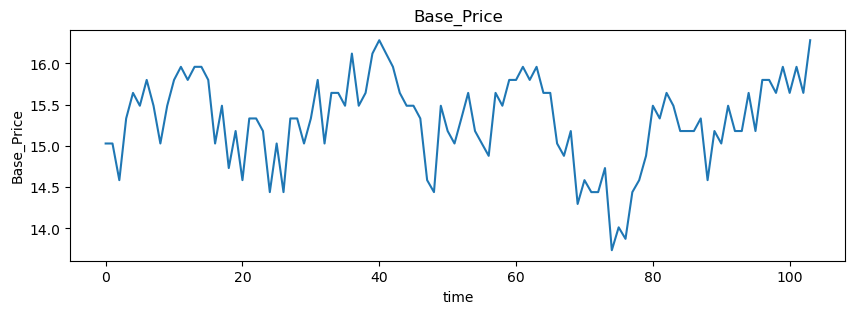

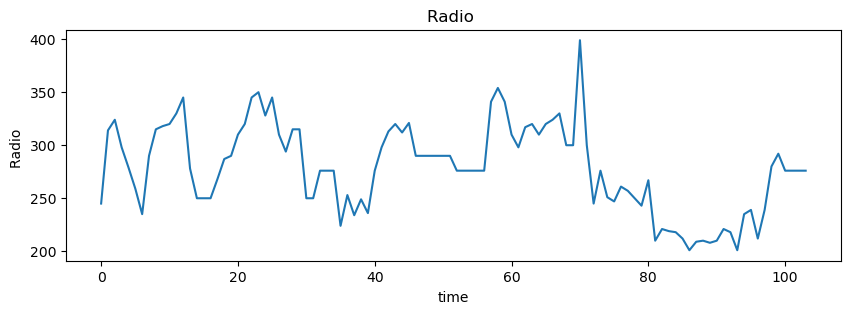

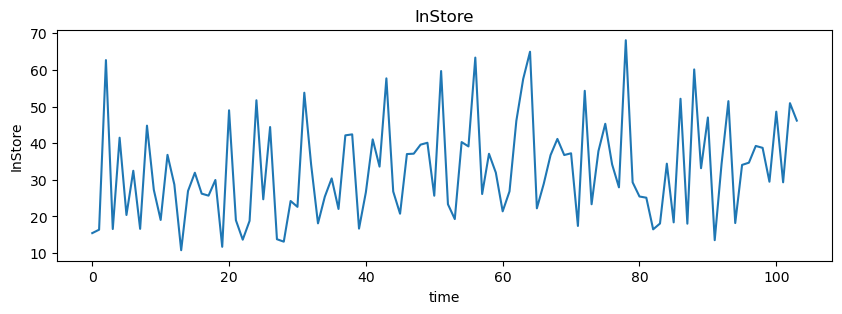

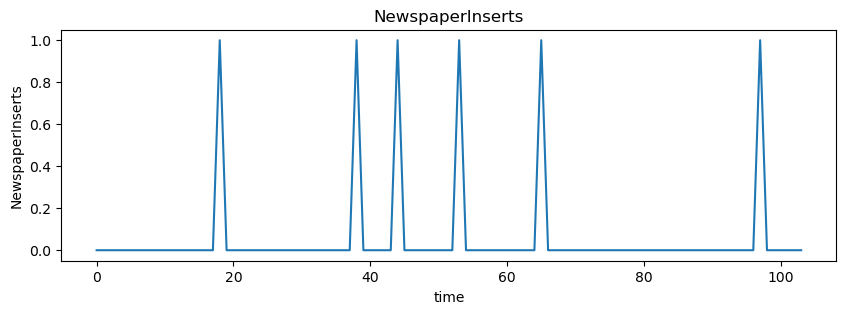

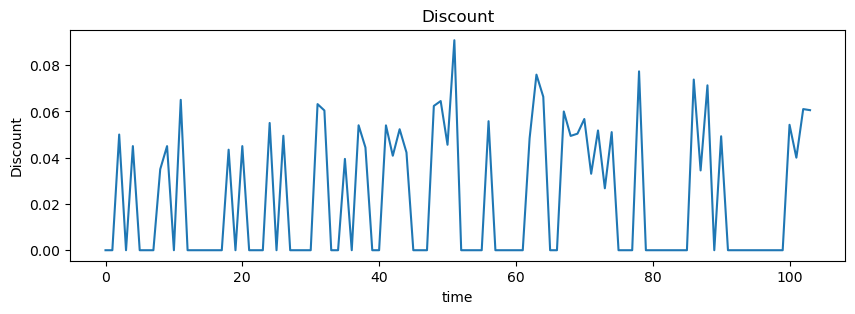

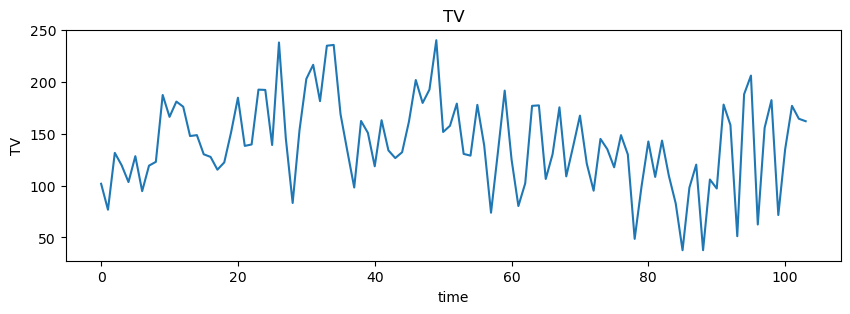

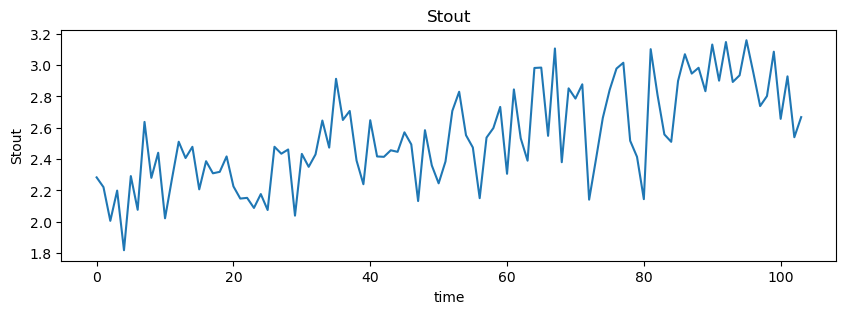

In [8]:
for i in df.columns:
    x = df[i]
    plt.figure(figsize=(10,3))
    plt.plot(range(df.shape[0]), x)
    plt.title(i)
    plt.xlabel('time')
    plt.ylabel(i)
    plt.show()

### SARIMAX

### stationarity

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

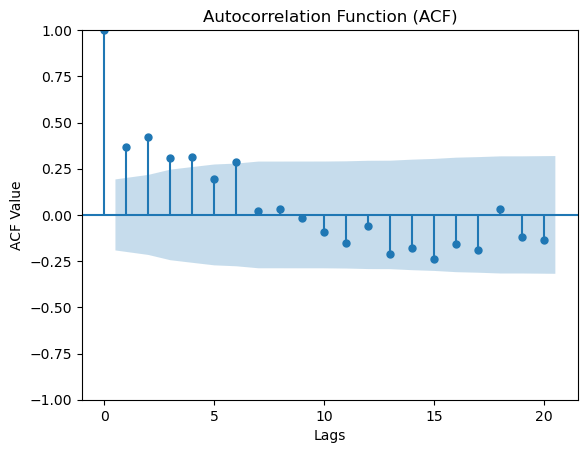

In [10]:
plot_acf(df['NewVolSales'], lags=20)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lags")
plt.ylabel("ACF Value")
plt.show()

In [11]:
adftest = adfuller(df['NewVolSales'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -4.186850161638528
P-Value: 0.004686036067487489
Number of lags: 1
Number of observations: 102
Critical Values: {'1%': -4.050384710217036, '5%': -3.454444406299236, '10%': -3.1527973675283265}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [12]:
# SARIMAX Model
y = df['NewVolSales']
x = df.drop(columns='NewVolSales')

In [13]:
ARIMAX_model = pm.auto_arima(df[['NewVolSales']], exogenous=df[['Base_Price', 'Radio ', 
                                                                'InStore', 'NewspaperInserts', 
                                                                'Discount', 'TV','Stout']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5,
                           start_P=0, seasonal=False,
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [14]:
ARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  104
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -905.630
Date:                Mon, 29 Jan 2024   AIC                           1815.260
Time:                        12:32:12   BIC                           1820.530
Sample:                             0   HQIC                          1817.394
                                - 104                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3345      0.033    -10.198      0.000      -0.399      -0.270
sigma2       2.42e+06   3.34e+05      7.236      0.000    1.76e+06    3.07e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.95   Jarque-Bera (JB):                 5.73
Prob(Q):                              0.05   Prob(JB):                         0.06
Heteroskedasticity (H):               0.51   Skew:                             0.57
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

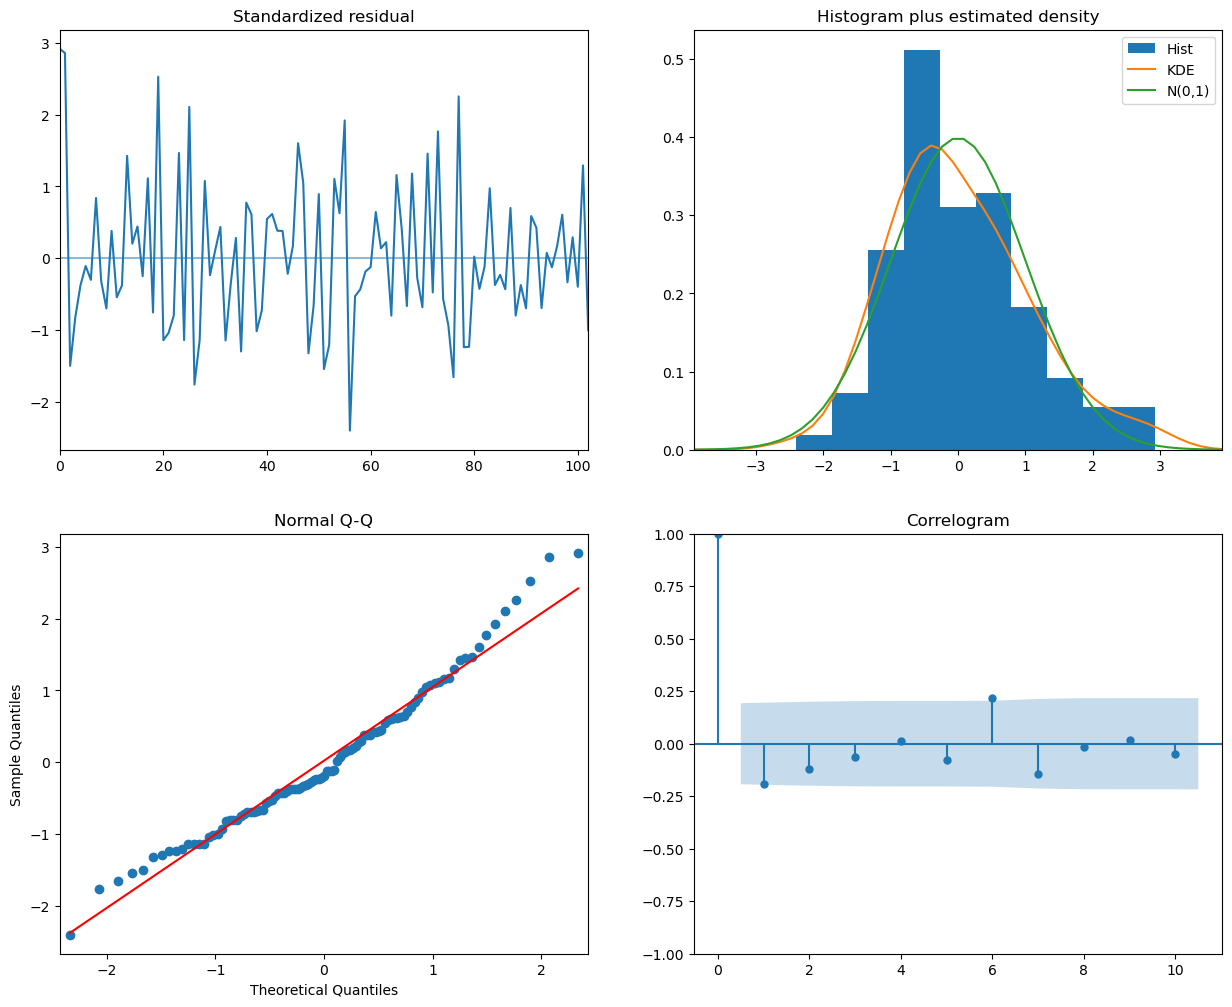

In [15]:
ARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

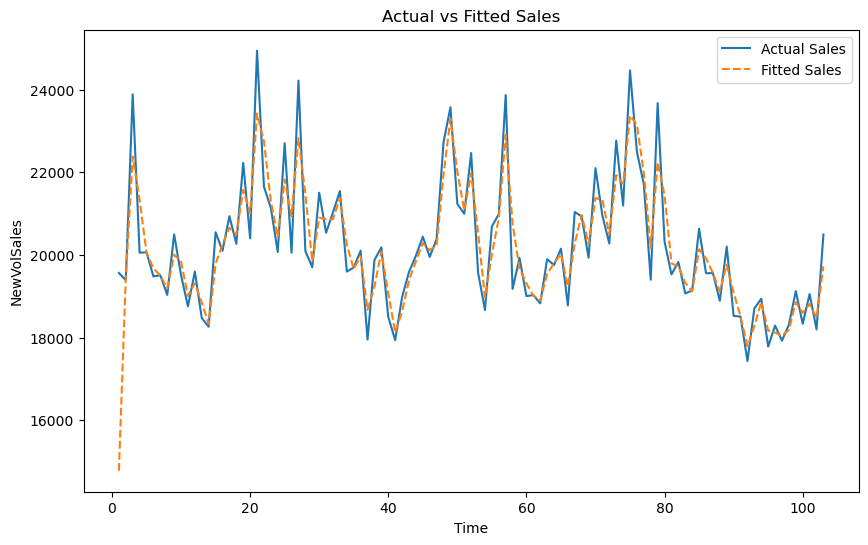

In [16]:
# Generate in-sample predictions
fitted_sales = ARIMAX_model.predict_in_sample(exogenous=df[['Base_Price', 'Radio ', 
                                                             'InStore', 'NewspaperInserts', 
                                                             'Discount', 'TV', 'Stout']])

# Plotting
plt.figure(figsize=(10,6))
plt.plot(range(1,len(fitted_sales)), df['NewVolSales'][0:len(fitted_sales)-1], label='Actual Sales')
plt.plot(range(1,len(fitted_sales)), fitted_sales[1:len(fitted_sales)], label='Fitted Sales', linestyle='--')
plt.title('Actual vs Fitted Sales')
plt.xlabel('Time')
plt.ylabel('NewVolSales')
plt.legend()
plt.show()

### Light GBM

In [17]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

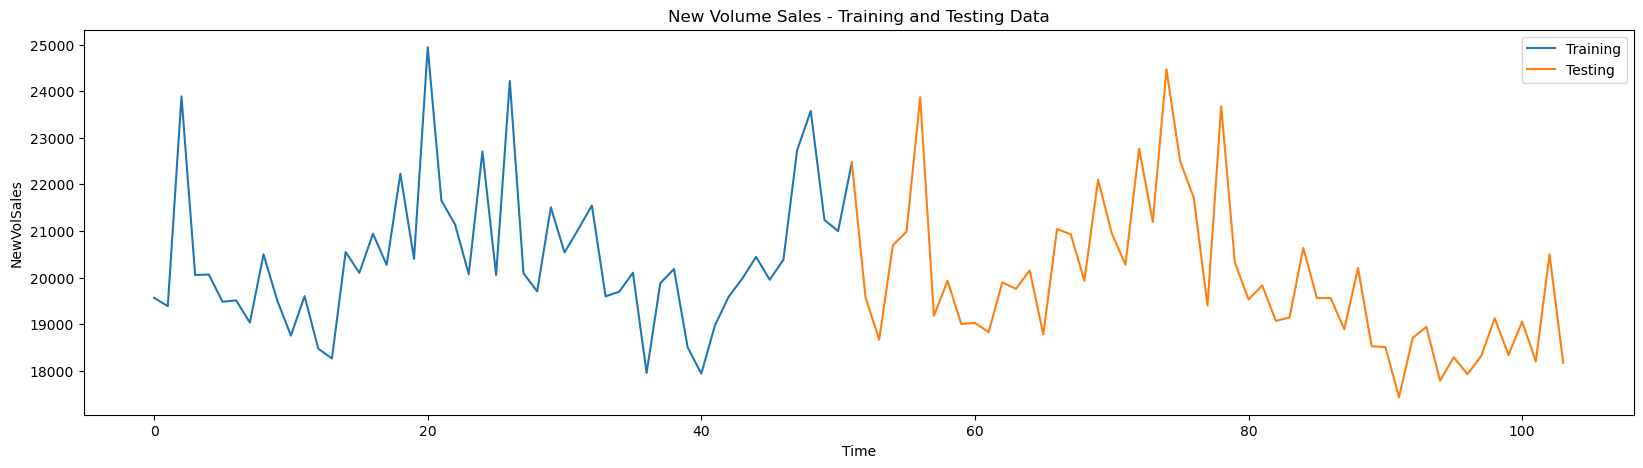

In [18]:
train_data = df.iloc[0:52,:]
test_data = df.iloc[51:104,:]
y_train = train_data['NewVolSales']
x_train = train_data.drop(columns='NewVolSales')
y_test = test_data['NewVolSales']
x_test = test_data.drop(columns='NewVolSales')

plt.figure(figsize=(20, 5))
plt.plot(train_data.index, y_train, label="Training")
plt.plot(test_data.index, y_test, label="Testing")
plt.legend()
plt.title('New Volume Sales - Training and Testing Data')
plt.xlabel('Time')
plt.ylabel('NewVolSales')
plt.show()

In [19]:
cv_split = TimeSeriesSplit(n_splits=4)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [3, 6, 10],
    "num_leaves": [10, 30, 100],
    "learning_rate": [0.05, 0.1, 0.3],
    "n_estimators": [50, 300, 500, 700],
    "colsample_bytree": [0.3, 0.5, 0.7, 1]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(x_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7, 1],
                         'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 300, 500, 700],
                         'num_leaves': [10, 30, 100]})

In [20]:
predictions = grid_search.predict(x_test)

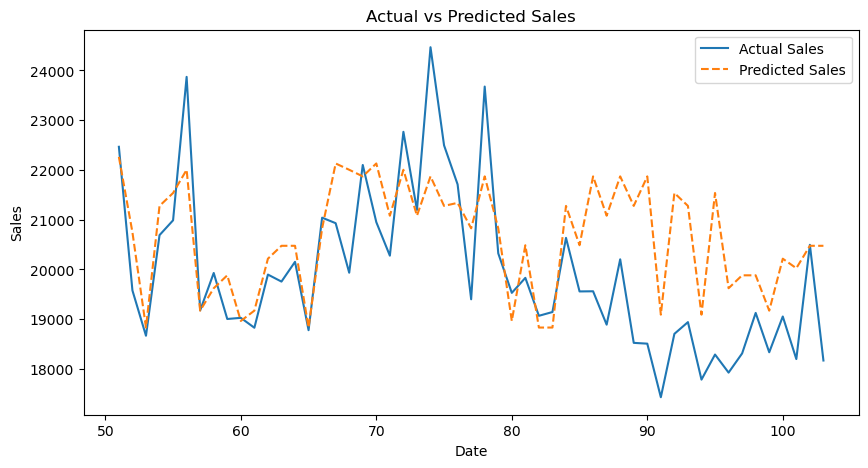

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, y_test, label='Actual Sales')
plt.plot(test_data.index, predictions, label='Predicted Sales', linestyle='--')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()